In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
from scipy import interpolate as interp
import scipy.ndimage
import matplotlib.pylab as pl
import time
import cv2 as cv
import ot
import math

# Fonctions SW/GradSW et données Image

In [2]:
def SW_gradSW(u,v,nbProj):#Pour deux images de même taille 
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    random_state = np.random.RandomState(None)
    Teta = random_state.normal(0., 1., [nbProj, d])
    np.linalg.norm(Teta)
    norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
    Teta = Teta / norm
    SW = 0
    gradSW = np.zeros((N,M,d))
    
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        u_sorted = np.sort(uteta)
        v_sorted = np.sort(vteta)
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        SW = SW + np.sum((u_sorted - v_sorted)**2)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        
        for j in range(N*M):
                gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
    SW = SW/nbProj
    
    return SW, gradSW

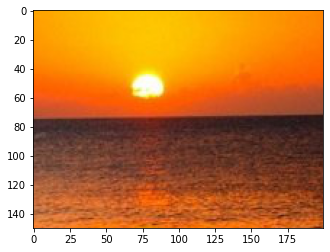

In [3]:
I1 = plt.imread('../data/coucher.jpg')
Xtrue = I1[100:250, 450:650, :]/255
plt.imshow(Xtrue)

In [4]:
def spectrale_degradation(img, b_low, b_high, adjoint):
    if(adjoint == 0):
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_low))
        for i in range(b_low):
            for j in range(d):
                out[:,:,i] = out[:,:,i] + img[:,:,j]
            
            out[:,:,i] = out[:,:,i]/d
        return out
    else :
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_high))
        for i in range(b_high):
            out[:,:,i] = 1/3*img[:,:,0]
        return out  

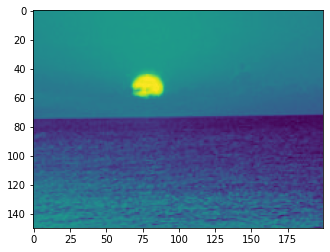

In [5]:
L_M = spectrale_degradation(Xtrue, 1, 3, 0)
plt.imshow(L_M)

In [6]:
def spatial_degradation(img,K,adjoint):
    sx , sy, d = img.shape[0], img.shape[1], img.shape[2]
    GaussBlur = cv.getGaussianKernel(5,5)
    GaussBlur_adj = GaussBlur.transpose()
        
    if adjoint==0: #Blur de l'image + sous-echantillonnage 
        imgBlurred = cv.filter2D(img, -1, GaussBlur)#Blur de l'image
        #Sous-echantillonnage
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy,d])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += imgBlurred[K*x+k,K*y+l, :]
                out[x,y,:]=tmp
                
    else: #sur-echantillonnage + Adjoint Blur (convolution avec transposee du Kernel de Blur)
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy,d])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= img[x,y]
        out = cv.filter2D(out, -1, GaussBlur_adj)#Adjoint du Blur
    
    return out/(K*K)

In [7]:
L_H = spatial_degradation(Xtrue, 2, 0)

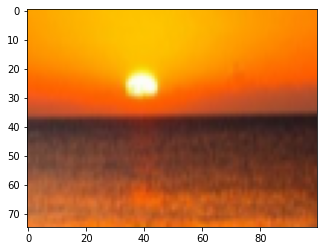

In [8]:
plt.imshow(L_H)

In [9]:
def reech_interp(img, K_ech):
    imgRec = np.zeros((K_ech*img.shape[0], K_ech*img.shape[1], img.shape[2]))
    for i in range(img.shape[2]):
        imgRec[:,:,i] = scipy.ndimage.zoom(img[:,:,i], K_ech, order=3)
    return imgRec

In [10]:
import skimage
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [11]:
def PSNR(reference, reconstruct):
    mse = np.mean((reference - reconstruct) ** 2)
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [12]:
def aSAM(reference, reconstruct):
    N = reference.shape[0]
    M = reference.shape[1]
    asam = 0
    for j in range(N*M):
        ps = np.dot(reference[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], reconstruct[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)].transpose())
        norm = np.linalg.norm(reference[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)])*np.linalg.norm(reconstruct[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)])
        asam = asam + np.arccos(ps/norm)
    asam = asam/(N*M)
    return asam

In [13]:
def acSSIM(reference, reconstruct):
    l = reference.shape[2]
    acssim = 0
    for i in range(l):
        acssim = acssim + skimage.metrics.structural_similarity(reference[:,:,i], reconstruct[:,:,i])
    acssim = 1 - acssim/l
    return acssim    

# Descente de gradient avec visualisation des normes indépendantes

In [27]:
def Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj):
    SW1, Gradient1 = SW_gradSW(spatial_degradation(X, K_ech, 0), L_H, nbProj)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M, nbProj)

    L2 = np.linalg.norm(X-reech_interp(L_H, K_ech))**2
    
    Gradient_quad = 2*(X-reech_interp(L_H, K_ech))
    Gradient1 = spatial_degradation(Gradient1, K_ech, 1)
    Gradient2 = spectrale_degradation(Gradient2, b_low, b_high, 1)
    grad = Lbd_SW1*Gradient1 + Lbd_SW2*Gradient2 + mu*Gradient_quad
    
    Fct = Lbd_SW1*SW1 + Lbd_SW2*SW2 + mu*L2
    
    return Fct, grad, Lbd_SW1*SW1, Lbd_SW2*SW2, mu*L2


In [32]:
def gradientDescente_pasConstant(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, pas):
    #X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    X = reech_interp(L_H, K_ech)
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
    Fonctionnelle = [Fct]
    SW_Z1 = [swZ1]
    SW_Z2 = [swZ2]
    NormeL2 = [nL2]

    X = X - pas*grad

    
    nu = 10**-6
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)

    Fonctionnelle.append(Fct)
    SW_Z1.append(swZ1)
    SW_Z2.append(swZ2)
    NormeL2.append(nL2)
    
    i = 1
    while(np.abs(Fonctionnelle[i]-Fonctionnelle[i-1])**2/np.abs(Fonctionnelle[i-1])**2 > nu and i <10000):
        X = X - pas*grad
        
        Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)

        Fonctionnelle.append(Fct)
        SW_Z1.append(swZ1)
        SW_Z2.append(swZ2)
        NormeL2.append(nL2)
        
        #if(i%10 == 0):
        print( 'iter = ', i , "fonction = ", Fonctionnelle[i])

        i = i+1
    
    return X, Fct, SW_Z1, SW_Z2, NormeL2

In [33]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 1, 1, 1, 5, 0.2)

iter =  1 fonction =  5668.426030684572
iter =  2 fonction =  1974.5194393074316
iter =  3 fonction =  609.6063722734747
iter =  4 fonction =  212.25968200825568
iter =  5 fonction =  75.21940998200927
iter =  6 fonction =  26.026661963075032
iter =  7 fonction =  9.528884485731657
iter =  8 fonction =  3.7446874332037545
iter =  9 fonction =  1.9063174859997174
iter =  10 fonction =  1.2282484232195119
iter =  11 fonction =  1.0297661657840296
iter =  12 fonction =  0.9324689320779598
iter =  13 fonction =  0.9062367950087704
iter =  14 fonction =  0.8957764345143446
iter =  15 fonction =  0.8837478725833956
iter =  16 fonction =  0.8492710143000275
iter =  17 fonction =  0.8759929538965747
iter =  18 fonction =  0.8808957774098805
iter =  19 fonction =  0.8755763930611545
iter =  20 fonction =  0.888014302359879
iter =  21 fonction =  0.8867414245067765
iter =  22 fonction =  0.8738640290698805
iter =  23 fonction =  0.8580748307658337
iter =  24 fonction =  0.863053026188389
iter = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


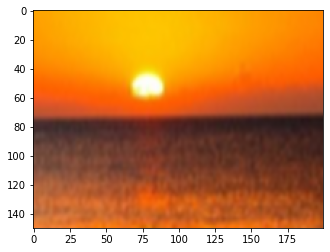

In [34]:
plt.imshow(X)

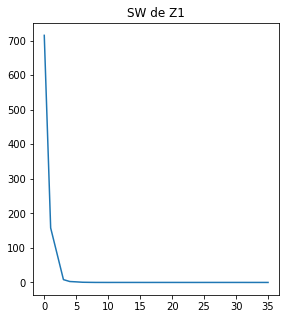

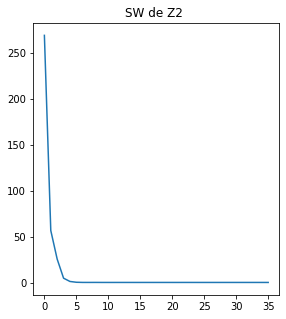

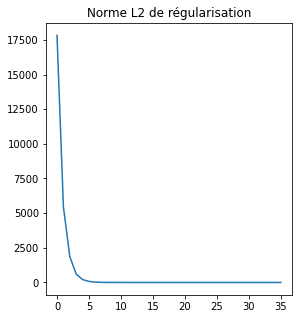

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [36]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))

erreur PSNR :  79.50613695444918
erreur SAM :  0.0215779948900612
erreur aSSIM :  0.09830007693942988


# Recherche Linéaire

In [39]:
def RechercheLineaire(out, fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj):
    i = 0
    alpha_l = 0
    alpha_r = 10000
    
    sigma = 10**-3
    teta = 0.2
    
    pas = 1.0
    
    g = np.linalg.norm(grad)
    
    fct_descendu, grad_descendu, notused1, notused2, notused3 = Fct_gradFct(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
    
    while(fct-fct_descendu < sigma*pas*g**2) or (g*np.linalg.norm(grad_descendu) < sigma*pas*g**2):
        if(fct-fct_descendu < sigma*pas*g**2):#Pas trop long
            alpha_r = pas
            pas = (alpha_l+alpha_r)/2
        else:
            if(g*np.linalg.norm(grad_descendu) < sigma*pas*g**2):
                alpha_l = pas
                pas = (alpha_l+alpha_r)/2
        i = i+1
        fct_descendu, grad_descendu, notused1, notused2, notused3 = Fct_gradFct(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
        if(pas <= 0.000001):
            return 0
    return pas
               

In [71]:
def gradientDescente_pasRL(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj):
    #X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    X = reech_interp(L_H, K_ech)
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
    Fonctionnelle = [Fct]
    SW_Z1 = [swZ1]
    SW_Z2 = [swZ2]
    NormeL2 = [nL2]
    pas = RechercheLineaire(X, Fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
    X = X - pas*grad

    
    nu = 10**-4
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)

    Fonctionnelle.append(Fct)
    SW_Z1.append(swZ1)
    SW_Z2.append(swZ2)
    NormeL2.append(nL2)
    
    i = 1
    while(np.abs(Fonctionnelle[i]-Fonctionnelle[i-1])**2/np.abs(Fonctionnelle[i-1])**2 > nu and i <10000):
        pas = RechercheLineaire(X, Fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
        X = X - pas*grad
        
        Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)

        Fonctionnelle.append(Fct)
        SW_Z1.append(swZ1)
        SW_Z2.append(swZ2)
        NormeL2.append(nL2)
        
        #if(i%10 == 0):
        print( 'iter = ', i ,  "pas = ", pas, "fonction = ", Fonctionnelle[i])

        i = i+1
    
    return X, Fct, SW_Z1, SW_Z2, NormeL2

# $\lambda_1 = 1$, $\lambda_2 = 1$, et $\mu = 1$

In [61]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 1, 1, 1, 5)

iter =  1 pas =  0.5 fonction =  1439.2350200431497
iter =  2 pas =  0.5 fonction =  1342.354204366206
iter =  3 pas =  0.25 fonction =  1094.5092835353748
iter =  4 pas =  0.5 fonction =  7.786138376456074
iter =  5 pas =  0.25 fonction =  2.8957550366352622
iter =  6 pas =  0.5 fonction =  0.8883687760756758
iter =  7 pas =  0 fonction =  0.8550735880361662
iter =  8 pas =  0.25 fonction =  0.8878082763739059


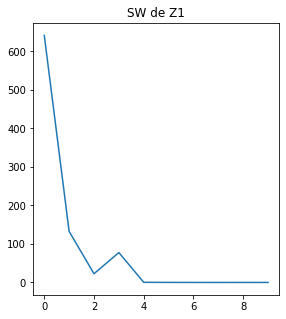

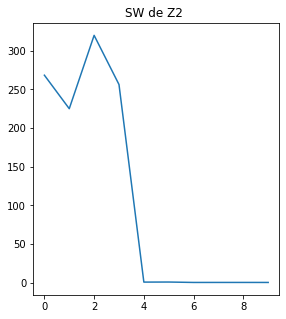

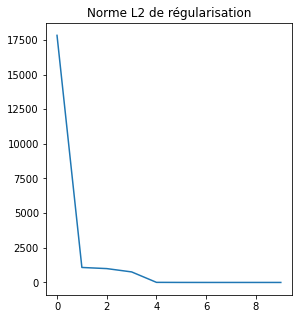

In [62]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [63]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))

erreur PSNR :  79.50787090764359
erreur SAM :  0.02154745829632597
erreur aSSIM :  0.09804414419477248


# $\lambda_1 = 1$, $\lambda_2 = 1$, et $\mu = 0.1$

In [67]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 1, 1, 0.1, 5)

iter =  1 pas =  1.0 fonction =  1923.6622280439112
iter =  2 pas =  0.5 fonction =  1739.2221064815085
iter =  3 pas =  1.0 fonction =  453.9515202879138
iter =  4 pas =  1.0 fonction =  284.49192549356434
iter =  5 pas =  1.0 fonction =  202.93857478144974
iter =  6 pas =  0.5 fonction =  175.74146458906776
iter =  7 pas =  1.0 fonction =  80.40292322551603
iter =  8 pas =  1.0 fonction =  55.92455315161939
iter =  9 pas =  1.0 fonction =  42.16175315035823
iter =  10 pas =  0.5 fonction =  40.979226012771875
iter =  11 pas =  1.0 fonction =  18.65823792130541
iter =  12 pas =  1.0 fonction =  13.820532880918048
iter =  13 pas =  1.0 fonction =  11.314315440866748
iter =  14 pas =  0.5 fonction =  10.98237436760516
iter =  15 pas =  1.0 fonction =  4.716198286223793
iter =  16 pas =  1.0 fonction =  3.456940826348283
iter =  17 pas =  1.0 fonction =  2.6434192840739463
iter =  18 pas =  1.0 fonction =  2.33328320154481
iter =  19 pas =  0.5 fonction =  2.05563131267975
iter =  20 pas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


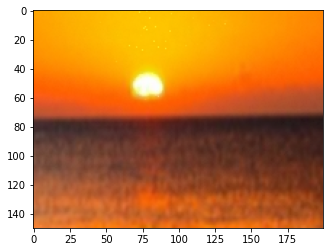

In [68]:
plt.imshow(X)

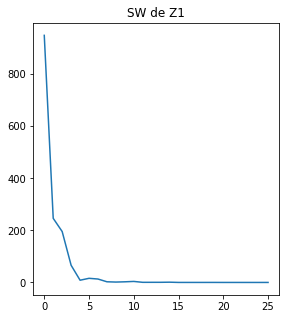

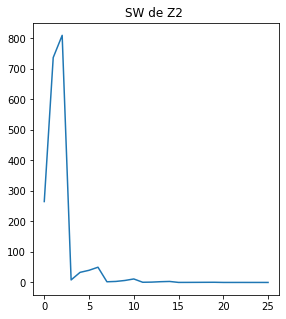

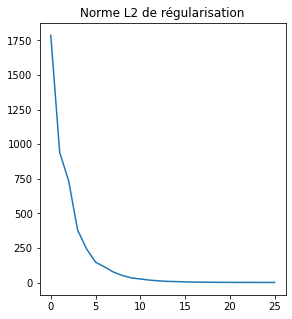

In [69]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [70]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))

erreur PSNR :  79.37122770468032
erreur SAM :  0.02276042677826939
erreur aSSIM :  0.10297075116895316


# $\lambda_1 = 1$, $\lambda_2 = 3$, et $\mu = 0.3$

In [57]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 1, 3, 0.3, 5)

iter =  1 pas =  0.25 fonction =  5702.9678291674045
iter =  2 pas =  0.25 fonction =  2496.072331183997
iter =  3 pas =  0.5 fonction =  1157.064074213663
iter =  4 pas =  0.25 fonction =  1089.5072895408773
iter =  5 pas =  0.25 fonction =  493.42115587443664
iter =  6 pas =  0.25 fonction =  296.343182977623
iter =  7 pas =  0.5 fonction =  195.17560817239413
iter =  8 pas =  0.25 fonction =  149.85825416848587
iter =  9 pas =  0.25 fonction =  82.91108889253593
iter =  10 pas =  0.5 fonction =  55.66429504598322
iter =  11 pas =  0.25 fonction =  39.674733160983585
iter =  12 pas =  0.5 fonction =  23.726346794085575
iter =  13 pas =  0.25 fonction =  19.16414747683153
iter =  14 pas =  0.5 fonction =  11.037914963113423
iter =  15 pas =  0.25 fonction =  10.700829064563834
iter =  16 pas =  0.25 fonction =  5.87612090625077
iter =  17 pas =  0.25 fonction =  3.809126176762733
iter =  18 pas =  0.5 fonction =  3.048255692238883
iter =  19 pas =  0.25 fonction =  2.4338728123609163


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


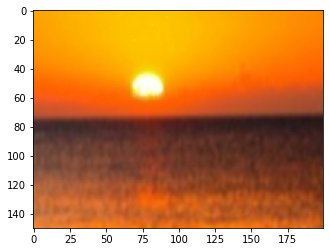

In [58]:
plt.imshow(X)

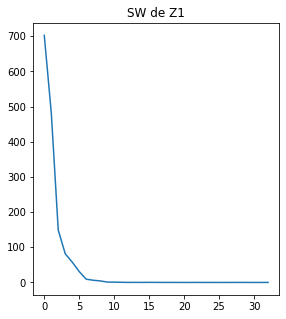

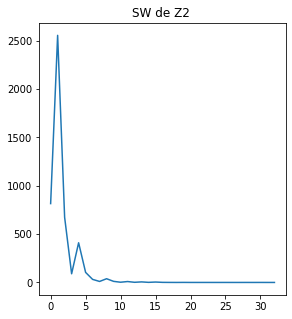

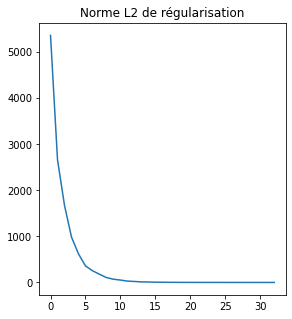

In [59]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [60]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))

erreur PSNR :  79.47772255287714
erreur SAM :  0.02234409972980224
erreur aSSIM :  0.09994758480974608


# $\lambda_1 = 1$, $\lambda_2 = 2$, et $\mu = 0.1$

In [64]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 1, 2, 0.1, 5)

iter =  1 pas =  0.5 fonction =  2135.325462897546
iter =  2 pas =  0.5 fonction =  1476.4142881494408
iter =  3 pas =  0.5 fonction =  1128.8504262989654
iter =  4 pas =  0.5 fonction =  897.4854121593569
iter =  5 pas =  0.5 fonction =  791.0424295632563
iter =  6 pas =  0.5 fonction =  618.261706274165
iter =  7 pas =  0.5 fonction =  511.27846082805837
iter =  8 pas =  0.25 fonction =  481.73592260888927
iter =  9 pas =  1.0 fonction =  209.1501762991873
iter =  10 pas =  0.5 fonction =  160.20138493635017
iter =  11 pas =  0.5 fonction =  128.56310477837866
iter =  12 pas =  0.5 fonction =  109.42012693349608
iter =  13 pas =  0.5 fonction =  94.16492520946338
iter =  14 pas =  0.5 fonction =  78.63690187580593
iter =  15 pas =  0.5 fonction =  69.34915210236183
iter =  16 pas =  0.5 fonction =  60.63352195347959
iter =  17 pas =  0.5 fonction =  51.281093823055144
iter =  18 pas =  0.5 fonction =  44.334534368401584
iter =  19 pas =  0.5 fonction =  40.25740224066709
iter =  20 p

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


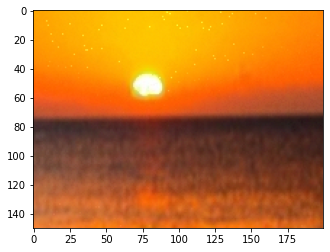

In [65]:
plt.imshow(X)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [66]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))

erreur PSNR :  78.70040980083346
erreur SAM :  0.02580445974686287
erreur aSSIM :  0.12672562741237214


In [73]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 1, 1, 0, 5)

iter =  1 pas =  1.0 fonction =  0.7841142873246397
iter =  2 pas =  1.0 fonction =  0.6226499476876746
iter =  3 pas =  0.5 fonction =  0.6351078193185826
iter =  4 pas =  1.0 fonction =  0.10506430191680746
iter =  5 pas =  1.0 fonction =  0.07447985804085516
iter =  6 pas =  1.0 fonction =  0.09577086318511673
iter =  7 pas =  1.0 fonction =  0.10199912227175223
iter =  8 pas =  1.0 fonction =  0.09710101884250703
iter =  9 pas =  1.0 fonction =  0.06972308128543256
iter =  10 pas =  1.0 fonction =  0.077794113922017
iter =  11 pas =  1.0 fonction =  0.0853740825794913
iter =  12 pas =  0.25 fonction =  0.07053137413401728
iter =  13 pas =  1.0 fonction =  0.08093423636990033
iter =  14 pas =  1.0 fonction =  0.08387536912138047
iter =  15 pas =  0.5 fonction =  0.09227608617232361
iter =  16 pas =  0.25 fonction =  0.05130115087863074
iter =  17 pas =  1.0 fonction =  0.09020647850515184
iter =  18 pas =  0.5 fonction =  0.07750571178821605


KeyboardInterrupt: 

In [ ]:
plt.imshow(X)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [75]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 1, 1, 0, 10, 0.0005)

iter =  1 fonction =  968.824802387895
iter =  2 fonction =  802.3168995127753
iter =  3 fonction =  1166.847509293184
iter =  4 fonction =  854.4719946131784
iter =  5 fonction =  1120.6982598192267
iter =  6 fonction =  1018.6230510379662
iter =  7 fonction =  647.0953359966375
iter =  8 fonction =  859.8167306618843
iter =  9 fonction =  931.2248527279019
iter =  10 fonction =  914.6302564291656
iter =  11 fonction =  843.2089157808239
iter =  12 fonction =  1256.5225205763445
iter =  13 fonction =  595.228171048655
iter =  14 fonction =  899.552306393645
iter =  15 fonction =  713.065452265263
iter =  16 fonction =  979.0506002892078
iter =  17 fonction =  1117.8252839759066
iter =  18 fonction =  878.9910039145798
iter =  19 fonction =  771.6819932777028
iter =  20 fonction =  854.0903985705015
iter =  21 fonction =  889.9713350411105
iter =  22 fonction =  891.326638965184
iter =  23 fonction =  1087.3125827252948


KeyboardInterrupt: 